# Change point model for real dataset

By Sang woo Ham (ecosang@gmail.com), Last edited on 09/15/2021

## Table of Contents

* [Introduction](#Introduction)
* [Dataset](#Dataset)
* [Example](#Example)
* [Discussion points](#Discussion-points)
* [References](#References)


# Introduction

Building energy analysis is a challenging task because of its complexity and lacks in systematic data collection. Therefore, the application of building energy model into the real dataset is complicated and even fails in many cases. In this notebook, we apply the change point model into the real dataset and discuss possible challenges.



# Dataset

Residential Building Stock Assessment(RBSA) dataset [1,2] is large-scale residential energy consumption survey prepared by Ecotope, Inc. for Northwest Energy Efficiency Alliance (NEEA). Two studies have beeen conducted in parallel. One is survey (phone call and billing information) based baseline study for large poluation. The other is detailed measurements for daily load shapes of end-use level. 

>*primary objective of the RBSA is to develop an inventory and profile of existing residential building stock in the Northwest based on field data from a representative, random sample of existing homes. The RBSA establishes the 2011 regional baseline for housing stock for three categories of residences: single-family homes, manufactured homes, and multifamily homes. The results will guide future planning efforts and provide a solid base for assessing energy savings on residential programs throughout the Northwest.*

The dataset is available from these two links [link1](https://neea.org/data/residential-building-stock-assessment) and [link2](https://neea.org/resources/2011-rbsa-metering-study). But, for the simplicity, we provide the pre-processed data in this notebook.







In [1]:

# loading required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # visualization
import pyarrow.feather as feather
import os

%matplotlib inline

The first part of the RBSA data is building metadata and yearly energy consumption. We've processed the data as a csv file. Below table shows the data.


In [2]:
# building metadata
survey=pd.read_csv("../data/rbsa/survey.csv")
survey.head(3)

,siteid,heat_elec,heat_elec_type,heat_elec_control,heat_elec_dist,heat_gas,heat_gas_type,heat_gas_control,heat_gas_dist,backup_elec,...,hw_elec,hw_gas,hw_btuhr,hw_kw,hw_solar,hw_conditioned,hw_year,hw_size,hw_type,ua_window
0,10040,1,baseboard,thermostat,zonal,0,none,none,none,0,...,1.0,0.0,0.0,5.5,0.0,1.0,1999.0,50.0,tank,83.050002
1,10388,1,baseboard,thermostat,zonal,0,none,none,none,1,...,1.0,0.0,0.0,4.5,0.0,1.0,1999.0,40.0,tank,74.249998
2,10887,1,hp,programmable,ducted,0,none,none,none,1,...,1.0,0.0,0.0,4.5,0.0,1.0,2003.0,50.0,tank,354.549995


| Name | Description |
| :--- | :----------- |
| siteid | An unique identifier for a a residential building |
| heat_[elec/gas] | Whether to have an electric/gas heating device. (1: yes, 0: no). |
| heat_[elec/gas]_type | Type of heating device. (`baseboard`, `boiler`, `hp`: heatpump, `faf`: forced air furnace, `gshp`: geo-source heatpump, `dualfuelhp`: dual fuel heatpump) |
| heat_[elec/gas]_control | Control method of heating device. (`programmable`: programmable thermostat, `thermostat`: non-programmable thermostat, `none`: no control device, `on/off` or `manual`: on/off switch|
| heat_[elec/gas]_dist | Heating distribution method of heating device. (`ducted`: air duct, `zonal`: device in each zone, `none`: no heating device.|
| backup_[elec/gas/other] | If there is backup [electric/gas/other] heating device.|
|num_[bath/bedroom]  | Number of bathroom/bedroom. |
|MoveIn  | Move in year. |
| year_built | Built year of the building. |
| homebusiness | If residnets are doing home business. |
| homerent | Home ownership (rent:1, non-rent: 0).|
| primaryres | Is this home your primary residence? (1: yes, 0: no) |
| income_support | Do you get any income support? (1: yes, 0: no) |
| workingoutside | How many people are working outside? |
|num_occupant  | Number of occupants. |
|has_[kid/senior]|Whether to have kids or senior people in the building.|
|dish_load|Number of dishwasher loads per week|
|wash_load|Number of clothes washer loads per week|
|ac_use|Whether to use air-conditioning device. (1: yes, 0: no).|
|heat_sp|Self-reported averaged heating setpoint [F].|
|heat_sp_night|Self-reported heating setpoint in night time [F].|
|ave_height|Average height of the building [ft].|
|ua_ceiling|Overall UA value of ceiling [BTU/(hr-F)].|
|has_dryer|Whether to have a dryer (or more) (1: yes, 0: no). |
|num_computer|Number of computers.|
| cook_[elec/gas] | Electric or gas cooking. |
| has_washer | Do you have a washer (1: yes, 0: no). |
| dryer_elec | Whether to have electric dryer (1: yes, 0: no). |
| dryer_gas | Whether to have gas dryer (1: yes, 0: no). |
| num_[audio/charger/game/tv] | Number of audio device, charger, game, or TV. |
| y_kwh |Yearly electricity consumption. |
| y_kbtu | Yearly gas consumption. |
| light_ex_watt | The total wattage of exterior lights installed [W]. |
| ua_floor | Overall UA value of floors [BTU/(hr-F)].  |
| light_in_watt | The total wattage of interior lights installed [W]. |
| bldg_type | Building type (Single residnetial home or multiplex building). |
| level_floor | Indicates the number of floors above grade present at site |
| num_room | Number of rooms |
|  tot_sqft | The conditioned area in square feet (calculated). |
| tot_vol | The estimated volume of the house (calculated). |
| fraction_window | Calculated ratio of window area square foot over site conditioned square foot. |
| [hdd65/cdd65] | Heating/cooling degree day. |
| population_city | Number of population in the city. |
| pv | Whether to have a photovoltaic. |
| year_ref | Refrigerator year of manufacture. |
| vol_ref | Volume of refrigerator [ft3]. |
| flow_shower | Size of shower fixtures [gpm] |
| ua_total | Overall UA value of all surfaces [BTU/(hr-F)]. |
| ua_wall | Overall UA value of walls [BTU/(hr-F)]. |
| hw_[elec/gas] | Electric or gas water heater (1: yes, 0: no). |
| hw_[btuhr/kw] | Size of gas/electric water heater [btu/hr or kW] |
| hw_solar | Whether to use solar water heater. |
| hw_conditioned | If the water heater is located in conditioned space. |
| hw_year | Water heater year of manufacture. |
| hw_size | Water heater size [Gallons]. |
| hw_type | Water heater type. |
| ua_window | Overall UA value of windows [BTU/(hr-F)]. |

The second part of the RBSA data is time-series meter data for each house. Hourly data is splitted into 8 pieces (i.e., `hourly_meter_data_x.feather`). Daily data is one file. Loading all data may be not available when you have a computer with small memory. Each file includes data of different houses. It includes appliance specific energy consumption in kWh. Also, it has outdoor and indoor air temperatures.


In [3]:
df=feather.read_feather("../data/rbsa/daily_meter_data.feather")

In [4]:
df.head(3)

,ymd,siteid,heating,heating_gas,cooling,lighting,plug,water_heater,water_haeter_gas,dryer,...,fridge,washer,microwave,range,total,other,rat,oat,thp,wst
0,2012-04-01,10388,9.169033,0.0,0.0,0.060109,5.600307,9.87,0.0,0.00,...,1.818958,0.000000,0.0,1.38,32.80,4.901593,17.805208,44.288941,0.000000,42.857639
1,2012-04-01,10887,68.340000,0.0,0.0,0.120777,2.597950,14.07,0.0,3.50,...,1.770670,0.092803,0.0,0.00,93.56,3.067801,17.612500,46.316493,136.723819,42.857639
2,2012-04-01,11418,17.400000,0.0,0.0,0.354287,1.791102,8.90,0.0,2.15,...,1.698230,0.150000,0.0,2.56,38.91,3.906381,16.837500,44.792986,76.022639,44.340278


|Name|Description|
|:-|:-|
|[ymd/timehour]|Day or Hourly timestamp|
|siteid|An unique identifier for a a residential building|
|heating|Heating device electricity consumption [kWh].|
|heating_gas|Heating device gas consumption [kWh].|
|cooling|Cooling device electricity consumption [kWh].|
|total|Total electricity consumption [kWh].|
|other|Total electricity - sum of all appliance specific electricity [kWh].|
|rat|Room air temperature [F].|
|oat|Outdoor air temperature [F].|
|thp| Heat pump vapor line temperature measured in Fahrenheit [F].|
|wst| Outdoor air temperature from the nearest weather station [F].|

The other columns (lighting, plug, water_heater, water_haeter_gas, dryer, dwasher, fridge, washer, microwave, range) show the electricity consumption of each appliance. 

# Example

Change point model [3-5] is used to analyze the impact of retrofit. However, it is also used to characterize house's building thermal performance based on the data. In this example, we use a simple example of how to build the change point model by using data of two houses.

In [83]:
# loading data

df=feather.read_feather("../data/rbsa/daily_meter_data.feather") # meter data
house_survey=survey[survey.siteid.isin(np.array([21355,22938]))] # meta data
# Select two houses. 21355, 22938
house1=df[df['siteid']==21355]
house2=df[df['siteid']==22938]


We use two houses (21355: House1, 22938: House2). These two houses show very similar characteristics except for House2 is bigger than House1. Also, House2 is in cold region because its Heating degree days higher.

In [85]:
house_survey[['siteid','heat_elec','heat_elec_control','heat_elec_type','year_built','tot_sqft','heat_sp','ua_total','hdd65','y_kwh']]

,siteid,heat_elec,heat_elec_control,heat_elec_type,year_built,tot_sqft,heat_sp,ua_total,hdd65,y_kwh
63,21355,1,programmable,faf,1979.0,1040.0,71.0,319.865288,4533.0,13913.793945
77,22938,1,programmable,faf,1974.0,1875.0,72.0,561.140015,5747.0,24571.248047


Visualize the data. It seems like House2 has cooling energy consumption, but House1's measurement does not have enough measurement in the cooling season (i.e., $oat>75^\circ\text{F}$). Therefore, we discard the data for $oat>75^\circ\text{F}$ in this analysis.

Text(0, 0.5, '$E_{total}$ [kWh]')

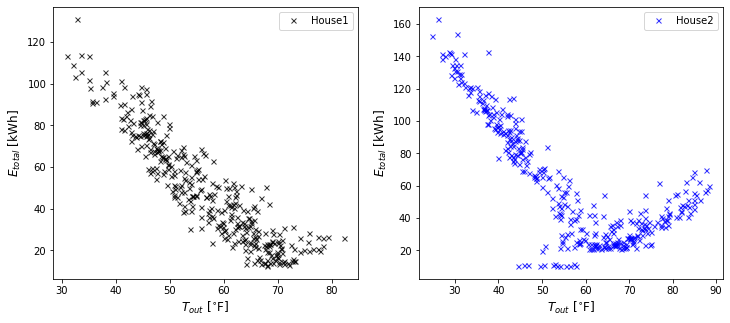

In [51]:
fig, ax =plt.subplots(nrows=1, ncols=2,  figsize=(12,5))
ax[0].plot(house1['oat'].to_numpy(), house1['total'].to_numpy(), "kx",label="House1",markersize=5,alpha=0.8)
#ax[0,0].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case1),'r-',label='Model (case1)',linewidth=1.0)
ax[0].legend(fontsize=10,loc="best")
ax[0].set_xlabel("$T_{out}$ [${^{\circ}}$F]",fontsize=12)
ax[0].set_ylabel("$E_{total}$ [kWh]",fontsize=12)
#ax[0].set_xlim([-22,30])
#ax[0].set_ylim([0,2])

ax[1].plot(house2['oat'].to_numpy(), house2['total'].to_numpy(), "bx",label="House2",markersize=5,alpha=0.8)
#ax[0,0].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case1),'r-',label='Model (case1)',linewidth=1.0)
ax[1].legend(fontsize=10,loc="best")
ax[1].set_xlabel("$T_{out}$ [${^{\circ}}$F]",fontsize=12)
ax[1].set_ylabel("$E_{total}$ [kWh]",fontsize=12)

In [86]:
# discard summer data
house1=house1[house1['oat']<75]
house2=house2[house2['oat']<75]

Also, it is numerically useful for learning change point model parameters to scale the data into [0,1] range by dividing each variable's maximum value.

In [87]:
# scaled data frame as shouse1 and shouse2
shouse1=house1.copy()
shouse2=house2.copy()

oat_max=100 # maximum value
total_max=200 # maximum value

shouse1['oat']=shouse1['oat']/oat_max
shouse2['oat']=shouse2['oat']/oat_max

shouse1['total']=shouse1['total']/total_max
shouse2['total']=shouse2['total']/total_max


Also, we put bounds to help the optimizer finds correct answer. beta0 is positive number as it represents baseline load. beta1 is negative value because it is heating coefficient. beta2 is in [0,1] range because the oat value is scaled into [0,1]. 

In [90]:
# Piecewise linear regression model (change point model)
# loading package
from scipy import optimize

def piecewise_linear(x, beta0, beta1, beta2):
    condlist = [x < beta2,  x >= beta2] # x<beta3 applies to lambda x: beta0+beta1*x. 
    funclist = [lambda x: beta0+beta1*(x-beta2), lambda x:beta0 ]
    return np.piecewise(x, condlist, funclist) 

# estimate theta* and covariance of theta*

theta_house1 , theta_cov_house1 = optimize.curve_fit(piecewise_linear, shouse1['oat'].to_numpy(), shouse1['total'].to_numpy(),bounds=((0,-np.inf,0),(np.inf,0,1))) #least square
theta_house2 , theta_cov_house2 = optimize.curve_fit(piecewise_linear, shouse2['oat'].to_numpy(), shouse2['total'].to_numpy(),bounds=((0,-np.inf,0),(np.inf,0,1))) #least square

The change model is well identified.

(0, 160)

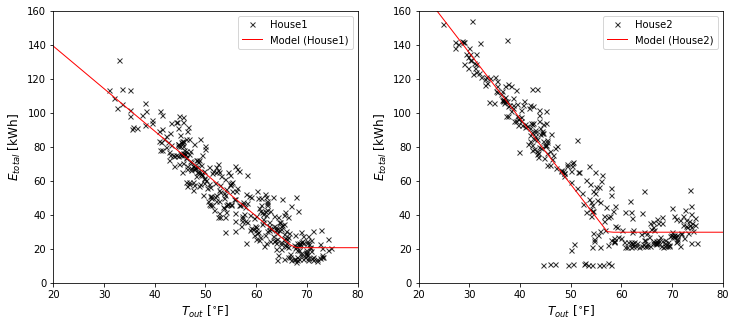

In [92]:
oat_grid=np.linspace(0.2,0.8,51)
fig, ax =plt.subplots(nrows=1, ncols=2,  figsize=(12,5))
ax[0].plot(house1['oat'].to_numpy(), house1['total'].to_numpy(), "kx",label="House1",markersize=5,alpha=0.8)
ax[0].plot(oat_grid*oat_max, piecewise_linear(oat_grid, *theta_house1)*total_max,'r-',label='Model (House1)',linewidth=1.0)
ax[0].legend(fontsize=10,loc="best")
ax[0].set_xlabel("$T_{out}$ [${^{\circ}}$F]",fontsize=12)
ax[0].set_ylabel("$E_{total}$ [kWh]",fontsize=12)
ax[0].set_xlim([20,80])
ax[0].set_ylim([0,160])

ax[1].plot(house2['oat'].to_numpy(), house2['total'].to_numpy(), "kx",label="House2",markersize=5,alpha=0.8)
ax[1].plot(oat_grid*oat_max, piecewise_linear(oat_grid, *theta_house2)*total_max,'r-',label='Model (House2)',linewidth=1.0)
ax[1].legend(fontsize=10,loc="best")
ax[1].set_xlabel("$T_{out}$ [${^{\circ}}$F]",fontsize=12)
ax[1].set_ylabel("$E_{total}$ [kWh]",fontsize=12)
ax[1].set_xlim([20,80])
ax[1].set_ylim([0,160])

beta1 indicates $HC\frac{\Delta t}{\eta_{\text{heat}}}$ where $HC=\left( UA+ c_{p,\text{air}} \rho_{\text{air}} \dot{V}_{\text{out}} \right)$. Therefore, the ratio of beta1 of two houses should be similar to the ratio of UA values of two houses. 

In [93]:
# ratio of slopes
theta_house1[1]/theta_house2[1]

0.6465352002433044

In [94]:
# ratio of UAs
house_survey['ua_total'].to_numpy()[0]/house_survey['ua_total'].to_numpy()[1]

0.5700275869586976

It is not exactly same because it is very simplified model. However, we can roughly estimate the overall UA factors without measuring/calculating UA values of the building based on the data. This can be used to identify the badly insulated building fairly quickly based on the data.

# Discussion points

There are several things that we can think of this approach.

1. How do you calculate expected energy savings when you upgrade building exterior walls or heating system efficiency?
2. What happens if we use hourly data for this analysis? 
3. How to deal with multiple sources of fuels?
4. Building size is not actually something related to retrofitting. Then, how to identify less insulated buildings based on the data? what are required information?
5. If building data does not look like to fit the change-point-model. What else we can do?


# References

[1] Baylon, D., Storm, P., Geraghty, K., & Davis, B. (2012). 2011 RESIDENTIAL BUILDING STOCK ASSESSMENT: SINGLE-FAMILY CHARACTERISTICS AND ENERGY USE. Report prepared by Ecotope Inc. for the Northwest Energy Efficiency Alliance.

[2] Larson, B., Gilman, L., Davis, R., Logsdon, M., Uslan, J., Hannas, B., Baylon, D., Storm, P., Mugford, V., & Kvaltine, N. (2014). Residential Building Stock Assessment: Metering Study. Report prepared by Ecotope Inc. for the Northwest Energy Efficiency Alliance.

[3] Kissock, J. K., Haberl, J. S., & Claridge, D. E. (2003). Inverse modeling toolkit: numerical algorithms. ASHRAE transactions, 109, 425. [(link)](http://www.eeperformance.org/uploads/8/6/5/0/8650231/ashrae_-_inverse_modeling_toolkit_-_numerical_algorithms.pdf)

[4] ASHRAE. (2014). ASHRAE Guideline 14–2014, Measurement of Energy, Demand, and Water Savings. [(link)](https://www.techstreet.com/standards/guideline-14-2014-measurement-of-energy-demand-and-water-savings?product_id=1888937)

[5] Server, F., Kissock, J. K., Brown, D., & Mulqueen, S. (2011). Estimating industrial building energy savings using inverse simulation. [(link)](https://ecommons.udayton.edu/cgi/viewcontent.cgi?article=1155&context=mee_fac_pub)